In [1]:
import os
import random
import numpy as np
import copy
import pandas as pd

os.environ["HF_TOKEN"] = 'your key'

In [4]:
%pip install -q -U transformers datasets accelerate trl peft bitsandbytes flash-attn

Note: you may need to restart the kernel to use updated packages.


### Construct instruction prompt from the input

In [2]:
def create_prompt(inputs: dict) -> str:
    """
    Function that creates prompt for poetry explanation.
    """
    return """
    You are given the poem "{title}" by {poet}.
    <poem>
    {content_before}
    {referent}
    {context_after}
    </poem>
    Explain the meaning of the following lines: "{referent}"
    """.format(
        title=inputs['poem_title'],
        poet=inputs['poet'],
        content_before=inputs['content_before'],
        context_after=inputs['context_after'],
        referent=inputs['referent']
    )

In [3]:
example = {
    'content_before': "The battle rent a cobweb diamond-strung\nAnd cut a flower beside a ground bird's nest\nBefore it stained a single human breast.\nThe stricken flower bent double and so hung.\nAnd still the bird revisited her young.\nA butterfly its fall had dispossessed\nA moment sought in air his flower of rest,\nThen lightly stooped to it and fluttering clung.\nOn the bare upland pasture there had spread\nO'ernight 'twixt mullein stalks a wheel of thread\nAnd straining cables wet with silver dew.",
    'referent': 'A sudden passing bullet shook it dry.',
    'context_after': 'The indwelling spider ran to greet the fly,\nBut finding nothing, sullenly withdrew.',
    'annotation': 'The serenity is, as the reader no doubt anticipates, broken by the shot described in this snappy line. The dryness may represent the loss of a source of life that invigorates the natural — and human — worlds.',
    'poet': 'Robert Frost',
    'poem_title': 'Range-finding'
}

In [4]:
create_prompt(example)

'\n    You are given the poem "Range-finding" by Robert Frost.\n    <poem>\n    The battle rent a cobweb diamond-strung\nAnd cut a flower beside a ground bird\'s nest\nBefore it stained a single human breast.\nThe stricken flower bent double and so hung.\nAnd still the bird revisited her young.\nA butterfly its fall had dispossessed\nA moment sought in air his flower of rest,\nThen lightly stooped to it and fluttering clung.\nOn the bare upland pasture there had spread\nO\'ernight \'twixt mullein stalks a wheel of thread\nAnd straining cables wet with silver dew.\n    A sudden passing bullet shook it dry.\n    The indwelling spider ran to greet the fly,\nBut finding nothing, sullenly withdrew.\n    </poem>\n    Explain the meaning of the following lines: "A sudden passing bullet shook it dry."\n    '

### Load train and validation datasets

In [6]:
from datasets import load_dataset
dataset = load_dataset("prettyvampire/genius_poems_annotations")

C:\Users\vlad-dev\miniconda3\envs\llm_sft\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
len(dataset['train']), len(dataset['validation'])

(2576, 366)

### Load pretrained model in 4 bit

In [8]:
import torch
torch.tensor(1).cuda().bfloat16() # to check bfloat16 availability

tensor(1., device='cuda:0', dtype=torch.bfloat16)

In [8]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ['HF_TOKEN'], add_eos_token=True)
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16 # torch.float16 if GPU doesn't support bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=nf4_config,
                                             device_map='auto',
                                             token=os.environ['HF_TOKEN'],
                                             attn_implementation="flash_attention_2",
                                             use_cache=False)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/it]


In [10]:
dataset["train"].features

{'content_before': Value(dtype='string', id=None),
 'referent': Value(dtype='string', id=None),
 'context_after': Value(dtype='string', id=None),
 'annotation': Value(dtype='string', id=None),
 'poet': Value(dtype='string', id=None),
 'poem_title': Value(dtype='string', id=None)}

### Construct chat template between user and assistant

In [ ]:
def apply_chat_template(example, tokenizer):
    text = create_prompt(example)
    messages = [
        {"role": "system", "content": "You are an expert in poetry."},
        {"role": "user", "content": text},
        {"role": "assistant", "content": example['annotation']}
    ]

    example["text"] = tokenizer.apply_chat_template(messages, tokenize=False)

    return example

column_names = list(dataset["train"].features)
dataset = dataset.map(apply_chat_template,
                      fn_kwargs={"tokenizer": tokenizer},
                      remove_columns=column_names,
                      desc="Applying chat template"
                     )


### Determine max length of your input

In [10]:
MAX_SEQUENCE_LENGTH = 512

In [ ]:
train_samples_lengths = [len(tokenizer(text=dataset['train'][index]['text'],is_split_into_words=False)['input_ids']) for index in range(len(dataset["train"]))]
test_samples_lengths = [len(tokenizer(text=dataset['test'][index]['text'],is_split_into_words=False)['input_ids']) for index in range(len(dataset["test"]))]

<Axes: >

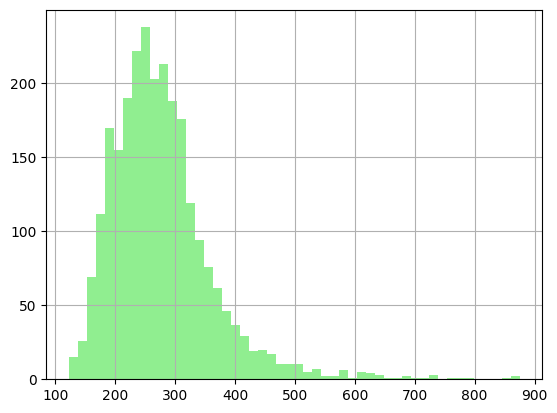

In [ ]:
import pandas as pd
pd.Series(train_samples_lengths).hist(bins=50, color='lightgreen')

<Axes: >

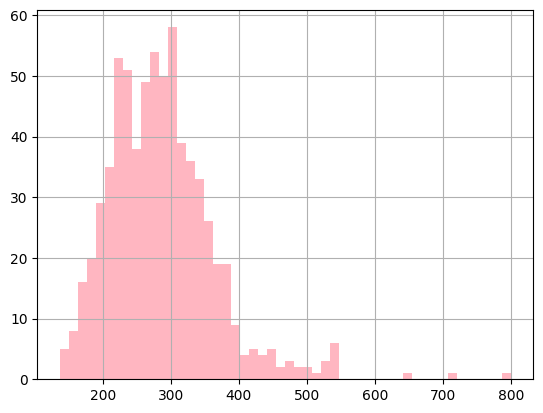

In [ ]:
pd.Series(test_samples_lengths).hist(bins=50, color='lightpink')

#### Filter out records that are longer than 512 tokens

In [13]:
dataset['train'] = dataset['train'].filter(lambda x: len(tokenizer(text=x['text'], is_split_into_words=False)['input_ids']) < MAX_SEQUENCE_LENGTH)
dataset['validation'] = dataset['validation'].filter(lambda x: len(tokenizer(text=x['text'], is_split_into_words=False)['input_ids']) < MAX_SEQUENCE_LENGTH)

In [14]:
len(dataset['train']), len(dataset['validation'])

(2525, 356)

### Define PEFT and SFT configs

In [15]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules="all-linear", #["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM"
)

In [17]:
import transformers
from trl import SFTTrainer, SFTConfig


torch.cuda.empty_cache()

sft_config = SFTConfig(
    max_seq_length=512,
    output_dir="outputs",
    report_to="none", # to prevent wandb API key error
    per_device_train_batch_size=1, # to fit on GPU
    per_device_eval_batch_size=1, # to fit on GPU
    gradient_accumulation_steps=4, # better stability for optimizer ~ batch size = 4 but low memory
    gradient_checkpointing=True, # for gradient accumulation
    bf16=True, # bf16 is more stable than fp16, available in Ampere GPUs and later
    num_train_epochs=1, # one epoch is enough
    logging_steps=1, 
    optim="paged_adamw_8bit", # paged for CPU memory in case GPU is not enough
    eval_strategy="steps",
    eval_steps=50 # to build training graph
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    args=sft_config,
    peft_config=lora_config,
    formatting_func=None
)

### Train

In [18]:
train_result = trainer.train()

C:\Users\vlad-dev\miniconda3\envs\llm_sft\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
C:\Users\vlad-dev\miniconda3\envs\llm_sft\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocas

Step,Training Loss,Validation Loss
50,1.832800,1.944836
100,1.897800,1.826170
150,1.751900,1.780192
200,1.860900,1.741657
250,2.079300,1.714025
300,1.903500,1.692754
350,1.720100,1.681152
400,1.369700,1.675502
450,1.974000,1.671325
500,1.822900,1.668295


C:\Users\vlad-dev\miniconda3\envs\llm_sft\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\vlad-dev\miniconda3\envs\llm_sft\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


In [19]:
train_result.metrics

{'train_runtime': 3602.8125,
 'train_samples_per_second': 0.701,
 'train_steps_per_second': 0.175,
 'total_flos': 3.076372627837747e+16,
 'train_loss': 1.8476953112568983,
 'epoch': 0.9996039603960396}

### Loading model from checkpoint

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

output_dir = "./outputs/checkpoint-631"
tokenizer = AutoTokenizer.from_pretrained(output_dir, add_eos_token=True)
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16 # torch.float16 if GPU doesn't support bfloat16
)

model = AutoModelForCausalLM.from_pretrained(output_dir,
                                             quantization_config=nf4_config,
                                             token=os.environ['HF_TOKEN'],
                                             device_map="auto")

C:\Users\vlad-dev\miniconda3\envs\llm_sft\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.35s/it]


*Selecting random example from the dataset*

In [4]:
sample = pd.read_csv('./data/annotations_dataset_validation.csv').fillna('').sample(n=1).to_dict(orient='records')[0]

In [5]:
print(create_prompt(sample))


    You are given the poem "Song of Beren and Lúthien" by J. R. R. Tolkien.
    <poem>
    One moment stood she, and a spell
His voice laid on her: Beren came,
And doom fell on Tinúviel
That in his arms lay glistening.
As Beren looked into her eyes
Within the shadows of her hair,
The trembling starlight of the skies
He saw there mirrored shimmering.
Tinúviel the elven-fair,
Immortal maiden elven-wise,
About him cast her shadowy hair
And arms like silver glimmering.
    Long was the way that fate them bore,
    O'er stony mountains cold and grey,
Through halls of iron and darkling door,
And woods of nightshade morrowless.
    </poem>
    Explain the meaning of the following lines: "Long was the way that fate them bore,"
    


### Sampling text from the model

In [7]:
text = create_prompt(sample)
messages = [
        {"role": "system", "content": "You are an expert in poetry."},
        {"role": "user", "content": text},
    ]

inputs = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

outputs = model.generate(**inputs,
                         max_new_tokens=128,
                         pad_token_id=tokenizer.eos_token_id)
                         #cache_implementation="quantized")
                         #cache_config={"backend": "quanto", "nbits": 4})

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

C:\Users\vlad-dev\miniconda3\envs\llm_sft\Lib\site-packages\transformers\models\llama\modeling_llama.py:602: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an expert in poetry.user

You are given the poem "Song of Beren and Lúthien" by J. R. R. Tolkien.
    <poem>
    One moment stood she, and a spell
His voice laid on her: Beren came,
And doom fell on Tinúviel
That in his arms lay glistening.
As Beren looked into her eyes
Within the shadows of her hair,
The trembling starlight of the skies
He saw there mirrored shimmering.
Tinúviel the elven-fair,
Immortal maiden elven-wise,
About him cast her shadowy hair
And arms like silver glimmering.
    Long was the way that fate them bore,
    O'er stony mountains cold and grey,
Through halls of iron and darkling door,
And woods of nightshade morrowless.
    </poem>
    Explain the meaning of the following lines: "Long was the way that fate them bore,"assistant

The fate of the two lovers is a long and difficult one, as we have already seen. Beren and Luthien are to be separated and are forced to travel far and wide. Th